In [1]:
from importlib import reload

from src.data import make_dataset

from src.models import config
config = reload(config)
from src.models.unet import UNet
from src.models.train_model import Trainer

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch

import albumentations as A

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import segmentation_models_pytorch as smp

## DATA
# Load train images
trainImages = config.train_orange_3_doors_images + config.train_black_5_doors_images

# Split images into train and val
train_dataset, val_dataset = random_split(trainImages, [1-config.VAL_SPLIT,config.VAL_SPLIT])
print(f"Dataset length: {len(trainImages)}")
print(f"Validation length: {len(val_dataset)}")
print(f"Train length: {len(train_dataset)}")

# define transformations
testTransform = A.Compose(
    [A.Resize(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH),
     #A.ToGray(p=1)
    ]
)

ShiftDic = {
    'y' : (0.3,0.5)
}

trainTransform = A.Compose(
    [
        A.Resize(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH),
        A.RandomBrightnessContrast(brightness_limit=(0,0.10), contrast_limit=0.10, p=0.5),
        A.ChannelShuffle(p=0.5),
        A.Affine(translate_percent=ShiftDic,always_apply=True),
        A.Affine(scale=(0.7,1), rotate=(-25,25), shear=0, p=0.5),
    ]
)

# create the train and val datasets
train_DS = make_dataset.imageArrayDataset(arrayPaths=train_dataset, #train_dataset
                                          bgPaths=config.background_images, 
                                          transforms=trainTransform)

val_DS = make_dataset.imageArrayDataset(arrayPaths=val_dataset,
                                        bgPaths=config.background_images, 
                                        transforms=testTransform)

test_DS = make_dataset.imageArrayDataset(arrayPaths=config.test_images,
                                         bgPaths=config.background_images, 
                                         transforms=testTransform, 
                                         test=True)

# create the training and val data loaders
trainLoader = DataLoader(train_DS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)
valLoader = DataLoader(val_DS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)
testLoader = DataLoader(test_DS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=config.NUM_WORKERS)

imageLoad, maskLoad = next(iter(trainLoader))
imageLoad, maskLoad = imageLoad.to(config.DEVICE), maskLoad.to(config.DEVICE)

print(imageLoad.shape, maskLoad.shape, type(imageLoad), type(maskLoad), imageLoad.dtype, maskLoad.dtype)
print(torch.unique(maskLoad))


## TRAIN MODELS
#DEFINE MODELS

#unet
Unet_scratch = UNet().to(config.DEVICE)


Unet_101 = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes = 10
)

#Deepnet
Deep18 = smp.DeepLabV3Plus(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=10,
)
Deep50 = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=10,
)
Deep101 = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=10,
)

#DEFINE TRAINERS
alpha_ = 0.35
beta_ = 0.65
criterion1 = smp.losses.FocalLoss(mode="multiclass")
criterion2 = smp.losses.DiceLoss(mode="multiclass")

opt_Unet = Adam(Unet_scratch.parameters(), lr=0.125e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_Unet = Trainer(
    model=Unet_scratch, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_Unet,
    device=config.DEVICE,
    modelPath="Models/UNET/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)

opt_Unet101 = Adam(Unet_101.parameters(), lr=0.125e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_Unet101 = Trainer(
    model=Unet_101, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_Unet101,
    device=config.DEVICE,
    modelPath="Models/UNET/101/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)

opt_deep18 = Adam(Deep18.parameters(), lr=0.1e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_deep18 = Trainer(
    model=Deep18, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_deep18,
    device=config.DEVICE,
    modelPath="Models/Deeplabv3/Resnet18/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)

opt_deep50 = Adam(Deep50.parameters(), lr=0.1e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_deep50 = Trainer(
    model=Deep50, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_deep50,
    device=config.DEVICE,
    modelPath="Models/Deeplabv3/Resnet50/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)

opt_deep101 = Adam(Deep101.parameters(), lr=0.1e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
trainer_deep101 = Trainer(
    model=Deep101, 
    criterion1=criterion1,
    criterion2=criterion2,
    testLoader=testLoader,
    optimizer=opt_deep101,
    device=config.DEVICE,
    modelPath="Models/Deeplabv3/Resnet101/",
    alpha=alpha_, #criterion1*alpha + criterion2*beta
    beta=beta_
)


#FIT TRAINERS
NUM_EPOCH = 40 #20 epochs is about 1hour-2hour depends on gpu
torch.cuda.empty_cache()

trainer_Unet.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=30)

torch.cuda.empty_cache()

trainer_Unet101.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=30)

torch.cuda.empty_cache()

trainer_deep18.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=30)

torch.cuda.empty_cache()

trainer_deep50.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=30)

torch.cuda.empty_cache()

trainer_deep101.fit(
    train_loader=trainLoader,
    val_loader=valLoader,
    epochs=NUM_EPOCH,
    patience=30)

torch.cuda.empty_cache()



Dataset length: 2833
Validation length: 28
Train length: 2805
torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
Starting Training...


Epoch 1: 100%|██████████| 176/176 [08:41<00:00,  2.96s/batch, loss=1.09]
INFO:root:Epoch 1/40 | Train loss: 1.0888621807098389 | Validation loss: 0 | IOU score: 0.25870102643966675 | Time/epoch: 521.04058 seconds
Epoch 2: 100%|██████████| 176/176 [08:04<00:00,  2.75s/batch, loss=1.02]
INFO:root:Epoch 2/40 | Train loss: 1.019416332244873 | Validation loss: 0 | IOU score: 0.41766127943992615 | Time/epoch: 484.35217 seconds
Epoch 3: 100%|██████████| 176/176 [07:40<00:00,  2.61s/batch, loss=0.978]
INFO:root:Epoch 3/40 | Train loss: 0.9778501987457275 | Validation loss: 0 | IOU score: 0.48985135555267334 | Time/epoch: 460.22169 seconds
Epoch 4: 100%|██████████| 176/176 [07:40<00:00,  2.62s/batch, loss=0.934]
INFO:root:Epoch 4/40 | Train loss: 0.9341269731521606 | Validation loss: 0 | IOU score: 0.49763089418411255 | Time/epoch: 460.47401 seconds
Epoch 5: 100%|██████████| 176/176 [07:40<00:00,  2.62s/batch, loss=0.951]
INFO:root:Epoch 5/40 | Train loss: 0.9507457613945007 | Validation loss: 

Starting Training...


Epoch 1: 100%|██████████| 176/176 [01:17<00:00,  2.27batch/s, loss=1.17]
INFO:root:Epoch 1/40 | Train loss: 1.1698310375213623 | Validation loss: 0 | IOU score: 0.17305207252502441 | Time/epoch: 77.54056 seconds
Epoch 2: 100%|██████████| 176/176 [01:17<00:00,  2.27batch/s, loss=1.03]
INFO:root:Epoch 2/40 | Train loss: 1.0276464223861694 | Validation loss: 0 | IOU score: 0.2044934630393982 | Time/epoch: 77.55351 seconds
Epoch 3: 100%|██████████| 176/176 [01:18<00:00,  2.26batch/s, loss=0.963]
INFO:root:Epoch 3/40 | Train loss: 0.9633890390396118 | Validation loss: 0 | IOU score: 0.265053927898407 | Time/epoch: 78.03327 seconds
Epoch 4: 100%|██████████| 176/176 [01:18<00:00,  2.24batch/s, loss=0.863]
INFO:root:Epoch 4/40 | Train loss: 0.8633067607879639 | Validation loss: 0 | IOU score: 0.4186989367008209 | Time/epoch: 78.63262 seconds
Epoch 5: 100%|██████████| 176/176 [01:18<00:00,  2.25batch/s, loss=0.795]
INFO:root:Epoch 5/40 | Train loss: 0.7954614162445068 | Validation loss: 0 | IOU

Starting Training...


Epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.27batch/s, loss=1.08]
INFO:root:Epoch 1/40 | Train loss: 1.0800318717956543 | Validation loss: 0 | IOU score: 0.2037999927997589 | Time/epoch: 41.25762 seconds
Epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.28batch/s, loss=0.92] 
INFO:root:Epoch 2/40 | Train loss: 0.9195258021354675 | Validation loss: 0 | IOU score: 0.46124768257141113 | Time/epoch: 41.08109 seconds
Epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.28batch/s, loss=0.847]
INFO:root:Epoch 3/40 | Train loss: 0.8473682999610901 | Validation loss: 0 | IOU score: 0.5284896492958069 | Time/epoch: 41.09816 seconds
Epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.29batch/s, loss=0.76] 
INFO:root:Epoch 4/40 | Train loss: 0.7601478099822998 | Validation loss: 0 | IOU score: 0.564509928226471 | Time/epoch: 41.02823 seconds
Epoch 5: 100%|██████████| 176/176 [00:40<00:00,  4.31batch/s, loss=0.731]
INFO:root:Epoch 5/40 | Train loss: 0.7311406135559082 | Validation loss: 0 | IO

Starting Training...


Epoch 1: 100%|██████████| 176/176 [01:07<00:00,  2.61batch/s, loss=1.02]
INFO:root:Epoch 1/40 | Train loss: 1.0160859823226929 | Validation loss: 0 | IOU score: 0.14945127069950104 | Time/epoch: 67.45752 seconds
Epoch 2: 100%|██████████| 176/176 [01:08<00:00,  2.58batch/s, loss=0.885]
INFO:root:Epoch 2/40 | Train loss: 0.8845340013504028 | Validation loss: 0 | IOU score: 0.4810698926448822 | Time/epoch: 68.13567 seconds
Epoch 3: 100%|██████████| 176/176 [01:07<00:00,  2.60batch/s, loss=0.777]
INFO:root:Epoch 3/40 | Train loss: 0.7773432731628418 | Validation loss: 0 | IOU score: 0.577393114566803 | Time/epoch: 67.60213 seconds
Epoch 4: 100%|██████████| 176/176 [01:07<00:00,  2.60batch/s, loss=0.727]
INFO:root:Epoch 4/40 | Train loss: 0.7270436882972717 | Validation loss: 0 | IOU score: 0.6147066950798035 | Time/epoch: 67.75173 seconds
Epoch 5: 100%|██████████| 176/176 [01:07<00:00,  2.59batch/s, loss=0.655]
INFO:root:Epoch 5/40 | Train loss: 0.6546512246131897 | Validation loss: 0 | IO

Starting Training...


Epoch 1: 100%|██████████| 176/176 [01:24<00:00,  2.08batch/s, loss=0.967]
INFO:root:Epoch 1/40 | Train loss: 0.9670138359069824 | Validation loss: 0 | IOU score: 0.4618547558784485 | Time/epoch: 84.6585 seconds
Epoch 2: 100%|██████████| 176/176 [01:24<00:00,  2.07batch/s, loss=0.841]
INFO:root:Epoch 2/40 | Train loss: 0.8413606882095337 | Validation loss: 0 | IOU score: 0.5915970802307129 | Time/epoch: 84.83503 seconds
Epoch 3: 100%|██████████| 176/176 [01:24<00:00,  2.08batch/s, loss=0.768]
INFO:root:Epoch 3/40 | Train loss: 0.7684085369110107 | Validation loss: 0 | IOU score: 0.6351029872894287 | Time/epoch: 84.61166 seconds
Epoch 4: 100%|██████████| 176/176 [01:24<00:00,  2.07batch/s, loss=0.695]
INFO:root:Epoch 4/40 | Train loss: 0.6946556568145752 | Validation loss: 0 | IOU score: 0.6513007879257202 | Time/epoch: 84.82804 seconds
Epoch 5: 100%|██████████| 176/176 [01:24<00:00,  2.08batch/s, loss=0.654]
INFO:root:Epoch 5/40 | Train loss: 0.6541635394096375 | Validation loss: 0 | IO

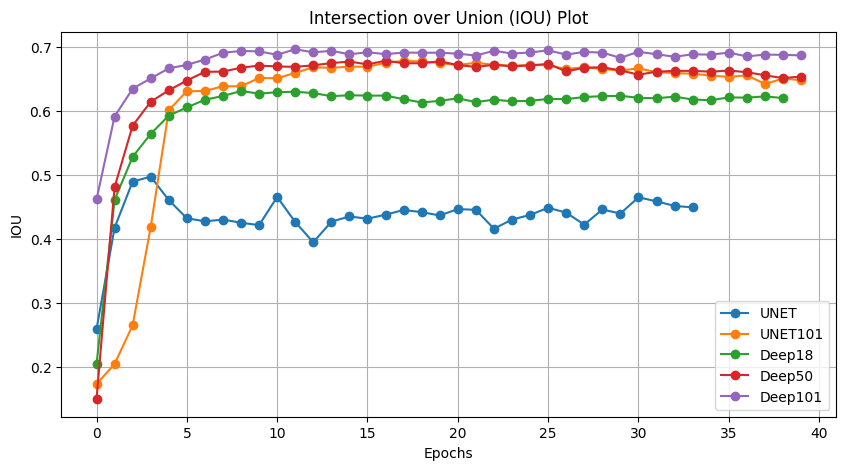

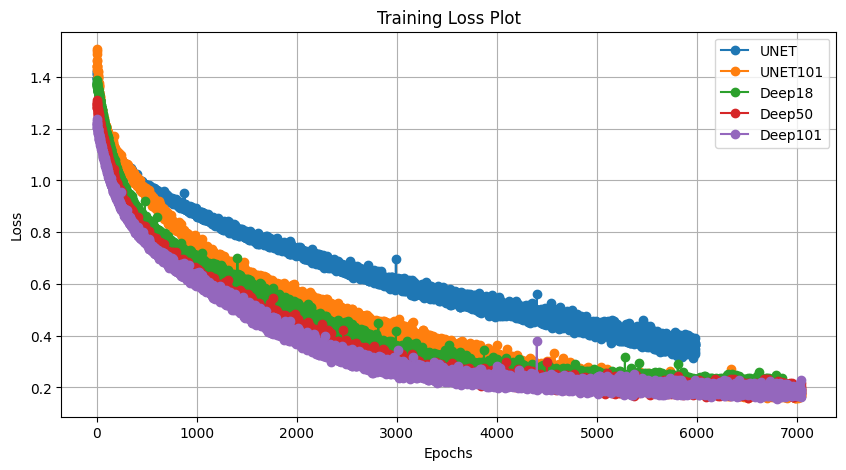

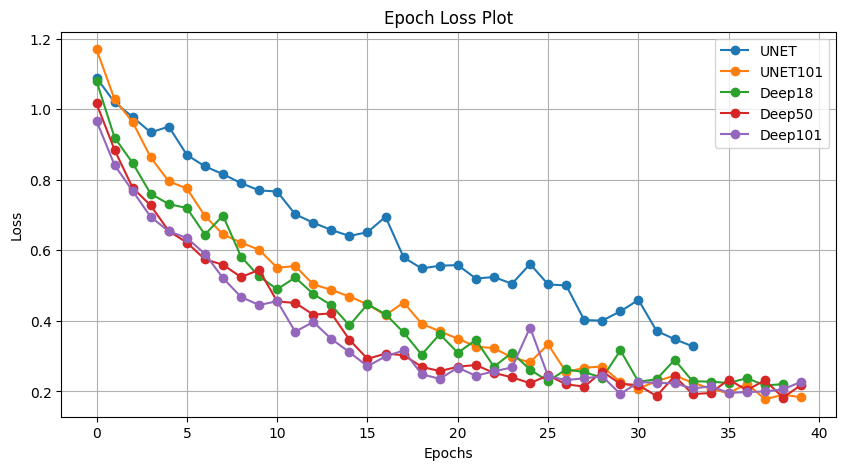

In [17]:
epochs_0 = range(0,len(trainer_Unet.IOU_score))
epochs_1 = range(0,len(trainer_Unet101.IOU_score))
epochs_2 = range(0,len(trainer_deep18.IOU_score))
epochs_3 = range(0,len(trainer_deep50.IOU_score))
epochs_4 = range(0,len(trainer_deep101.IOU_score))

Model_name_0 = "UNET"
Model_name_1 = "UNET101"
Model_name_2 = "Deep18"
Model_name_3 = "Deep50"
Model_name_4 = "Deep101"

# IOU plot for four models
plt.figure(figsize=(10, 5))
plt.plot(epochs_0, trainer_Unet.IOU_score, marker='o', label=Model_name_0)
plt.plot(epochs_1, trainer_Unet101.IOU_score, marker='o', label=Model_name_1)
plt.plot(epochs_2, trainer_deep18.IOU_score, marker='o', label=Model_name_2)
plt.plot(epochs_3, trainer_deep50.IOU_score, marker='o', label=Model_name_3)
plt.plot(epochs_4, trainer_deep101.IOU_score, marker='o', label=Model_name_4)
plt.title('Intersection over Union (IOU) Plot')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.show()

# Training Loss plot for four models
plt.figure(figsize=(10, 5))
plt.plot(trainer_Unet.train_step_loss, marker='o', label=Model_name_0)
plt.plot(trainer_Unet101.train_step_loss, marker='o', label=Model_name_1)
plt.plot(trainer_deep18.train_step_loss, marker='o', label=Model_name_2)
plt.plot(trainer_deep50.train_step_loss, marker='o', label=Model_name_3)
plt.plot(trainer_deep101.train_step_loss, marker='o', label=Model_name_4)
plt.title('Training Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Epoch Loss plot for four models
plt.figure(figsize=(10, 5))
plt.plot(epochs_0, trainer_Unet.train_loss_, marker='o', label=Model_name_0)
plt.plot(epochs_1, trainer_Unet101.train_loss_, marker='o', label=Model_name_1)
plt.plot(epochs_2, trainer_deep18.train_loss_, marker='o', label=Model_name_2)
plt.plot(epochs_3, trainer_deep50.train_loss_, marker='o', label=Model_name_3)
plt.plot(epochs_4, trainer_deep101.train_loss_, marker='o', label=Model_name_4)
plt.title('Epoch Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

import pickle

# Create a dictionary to store the plotted data
plotted_data = {
    'epochs_0': epochs_0,
    'iou_score_0': trainer_Unet.IOU_score,
    'epochs_1': epochs_1,
    'iou_score_1': trainer_Unet101.IOU_score,
    'epochs_2': epochs_2,
    'iou_score_2': trainer_deep18.IOU_score,
    'epochs_3': epochs_3,
    'iou_score_3': trainer_deep50.IOU_score,
    'epochs_4': epochs_4,
    'iou_score_4': trainer_deep101.IOU_score,
    'train_step_loss_0': trainer_Unet.train_step_loss,
    'train_step_loss_1': trainer_Unet101.train_step_loss,
    'train_step_loss_2': trainer_deep18.train_step_loss,
    'train_step_loss_3': trainer_deep50.train_step_loss,
    'train_step_loss_4': trainer_deep101.train_step_loss,
    'train_loss_0': trainer_Unet.train_loss_,
    'train_loss_1': trainer_Unet101.train_loss_,
    'train_loss_2': trainer_deep18.train_loss_,
    'train_loss_3': trainer_deep50.train_loss_,
    'train_loss_4': trainer_deep101.train_loss_,
    'model_names': [Model_name_0, Model_name_1, Model_name_2, Model_name_3, Model_name_4]
}

# Pickle the data
with open('plotted_data.pkl', 'wb') as file:
    pickle.dump(plotted_data, file)

torch.Size([16, 10, 256, 256])
torch.Size([16, 256, 256])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


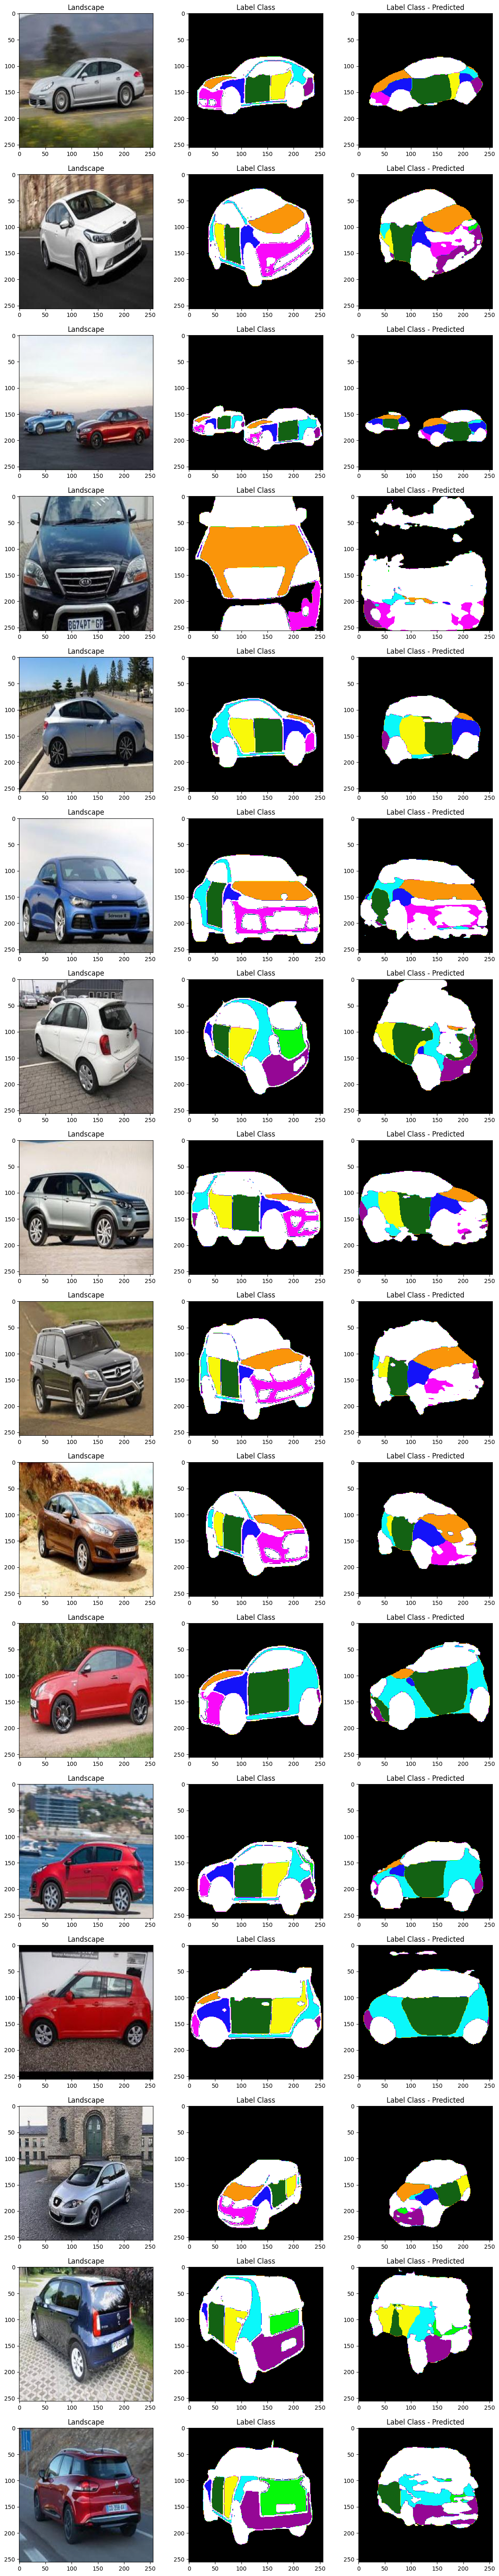

In [16]:
Deep101.load_state_dict(torch.load("./models/Deeplabv3/Resnet101/c_11_IOU_0.6969.pth.tar"))

X, Y = next(iter(testLoader))
X, Y = X.to(config.DEVICE), Y.to(config.DEVICE)
Y_pred = Deep101(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)
print(torch.unique(Y_pred))

colors_info = {
    0:  (0,0,0),            # background to black
    10: (250, 149, 10),     # orange
    20: (19, 98, 19),       # dark green
    30: (249, 249, 10),     # yellow
    40: (10, 248, 250),     # cyan
    50: (149, 7, 149),      # purple
    60: (5, 249, 9),        # light green
    70: (20, 19, 249),      # blue
    80: (249, 9, 250),      # pink
    90: 'white'              # no color (NA)
}
# Convert RGB values to floats between 0 and 1
colors_info = {key: value if isinstance(value, str) else (value[0] / 255, value[1] / 255, value[2] / 255) for key, value in colors_info.items()}
# Create a custom colormap
carseg_cmap = ListedColormap(colors_info.values(), name="custom_cmap")


test_batch_size=16
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))


for i in range(test_batch_size):

    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class,cmap=carseg_cmap)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted,cmap=carseg_cmap)
    axes[i, 2].set_title("Label Class - Predicted")